In [2]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.distance import great_circle
from scipy.spatial import distance
from pulp import *
from sklearn.cluster import KMeans

os.chdir('/Users/chengchen/Desktop/Insight/project/')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Demand for Charging

* The dataset below is from Toronto's Transportation Tomorrow Survey 2016. It contains information on number of trips made to 44 different wards in Toronto. For more information on wards, please see https://www.toronto.ca/city-government/data-research-maps/neighbourhoods-communities/ward-profiles/44-ward-model/


In [3]:
df = pd.read_excel('data/raw/tts2016_ward_Toronto.xlsx')
df_trip = df[df.variable.str.contains('Number of trips made to the area as auto driver during ')].copy()
df_trip['time_of_day'] = ['morning', 'afternoon']
df_trip = df_trip.drop('variable', axis = 1).transpose()
df_trip['ward'] = df_trip.index
df_trip.columns = ['morning trips', 'afternoon trips', 'ward']
df_trip.to_excel('data/processed/trip_to_wards.xlsx', index=False)

* Merge the number of trips data into wards' shapefile and draw the map to see traffic destinations during AM/PM peak hours.  

In [4]:
df_trip.head()

,morning trips,afternoon trips,ward
City of Toronto,639546,639519,City of Toronto
Ward 1,17318,11704,Ward 1
Ward 2,26302,16637,Ward 2
Ward 3,10726,16517,Ward 3
Ward 4,6783,15634,Ward 4


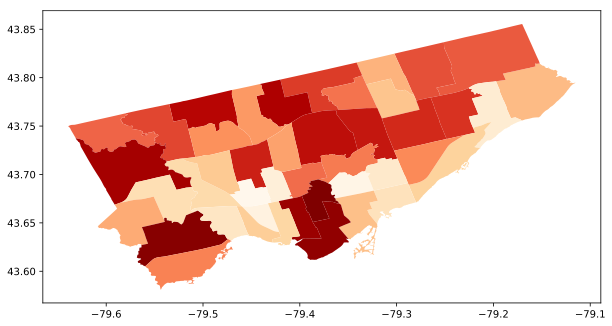

In [5]:
shp_path = 'data/raw/Toronto_wards/icitw_wgs84.shp'
df_ward = gpd.read_file(shp_path)
df_ward['SCODE_NAME']=df_ward['SCODE_NAME'].astype(int)
df_ward['ward'] = 'Ward '+ df_ward['SCODE_NAME'].astype(str)
ward_trip_shp = df_ward.merge(df_trip, how='left')
ward_trip_shp.plot(figsize=(10,10), column = 'morning trips',cmap='OrRd')

In [6]:
#ward_trip_shp.plot(figsize=(10,10), column = 'afternoon trips',cmap='Blues')

* Combine with Census Tract shapefiles

In [7]:
shp_path2 ='data/raw/Toronto_shp/Toronto_CMA_01_popn_age_sex_marital.shp'
df_TRT_shp = gpd.read_file(shp_path2)
ward_trip_shp.crs = {'init' :'epsg:4326'}
df_TRT_shp.crs == ward_trip_shp.crs
ward_trip_shp = ward_trip_shp.to_crs(df_TRT_shp.crs)
CT_trips = gpd.sjoin(df_TRT_shp, ward_trip_shp, how="inner", op="intersects")
# get the CTs' centroids
CT_trips['centroid'] = CT_trips['geometry'].centroid
CT_trips['long']=CT_trips.centroid.x
CT_trips['lat']=CT_trips.centroid.y

In [9]:
CT_trips.columns

Index(['CTNAME', 'GEOGRAPHY', 'CTUID', 'CMAUID', 'PRUID', 'POP01', 'POP06',
       'POPCHG', 'L_AREA', 'POP06RD',
       ...
       'TYPE_CODE', 'OBJECTID', 'SHAPE_AREA', 'SHAPE_LEN', 'ward',
       'morning trips', 'afternoon trips', 'centroid', 'long', 'lat'],
      dtype='object', length=123)

In [10]:
CT_trips_clean = CT_trips[['CTNAME','POP06', 'L_AREA', 'ward', 'long', 'lat', 'morning trips', 'afternoon trips']].copy()
CT_trips_clean.loc[CT_trips_clean['morning trips'].isnull(),'morning trips'] = 0
CT_trips_clean.loc[CT_trips_clean['afternoon trips'].isnull(),'afternoon trips'] = 0

* evenly distribute the Census Tracts to different wards if they intersect with various wards

In [11]:
CT_trips_clean['CT_ward_count'] = CT_trips_clean.groupby(['CTNAME'])['CTNAME'].transform('size')
CT_trips_clean['CT_ward_weight'] = 1/CT_trips_clean['CT_ward_count']
CT_trips_clean['ward_count_weighted']=CT_trips_clean['CT_ward_weight'].groupby(CT_trips_clean['ward']).transform('sum')
CT_trips_clean['CT_avg_AM_trips'] = CT_trips_clean['morning trips']/CT_trips_clean['ward_count_weighted']*CT_trips_clean['CT_ward_weight']
#CT_trips_clean['CT_weighted_AM_trips'] = CT_trips_clean['CT']
CT_trips_clean['CT_AM_trips'] = CT_trips_clean['CT_avg_AM_trips'].groupby(CT_trips_clean['CTNAME']).transform('sum')

CT_trips_clean=CT_trips_clean.drop_duplicates(subset = ['CTNAME'])
CT_trips_clean=CT_trips_clean.set_index('CTNAME')
# each row represents a census tract, the info of "# trips in the ward that this CT belongs to" is added
CT_trips_clean = CT_trips_clean[['POP06', 'L_AREA', 'ward', 'long', 'lat', 'CT_AM_trips']]


In [12]:
CT_trips_clean.head()

,POP06,L_AREA,ward,long,lat,CT_AM_trips
CTNAME,,,,,,
0001.00,571,6.10,Ward 28,-79.335397,43.647242,1285.060838
0002.00,627,3.17,Ward 28,-79.381859,43.623125,2581.374046
0012.00,8053,1.11,Ward 28,-79.390339,43.640195,2249.919581
0013.00,6315,0.76,Ward 28,-79.375291,43.643822,2249.919581
0014.00,548,0.47,Ward 28,-79.382101,43.648612,2143.473269


In [13]:
CT_trips_clean.to_excel('data/cleaned/optimization_CT_AM_trips.xlsx')

In [22]:
CT_trips_clean.shape
CT_trips_clean['CTNAME']= CT_trips_clean.index
CT_trips_clean.head()

,POP06,L_AREA,ward,long,lat,CT_AM_trips,CTNAME
CTNAME,,,,,,,
0001.00,571,6.10,Ward 28,-79.335397,43.647242,1285.060838,0001.00
0002.00,627,3.17,Ward 28,-79.381859,43.623125,2581.374046,0002.00
0012.00,8053,1.11,Ward 28,-79.390339,43.640195,2249.919581,0012.00
0013.00,6315,0.76,Ward 28,-79.375291,43.643822,2249.919581,0013.00
0014.00,548,0.47,Ward 28,-79.382101,43.648612,2143.473269,0014.00


In [28]:
# merge with count of charging stations
shp_path = 'data/processed/shape_join_points.shp'
df_TRT_shp = gpd.read_file(shp_path)
df_TRT_shp = df_TRT_shp[['CTNAME','charging s']]
CT_trips_pts = pd.merge(df_TRT_shp, CT_trips_clean, on = 'CTNAME')
CT_trips_pts = CT_trips_pts.set_index('CTNAME')
CT_trips_pts.head()
CT_trips_pts.to_excel('data/cleaned/optimization_CT_AM_trips_chgstn.xlsx')

## Locations of Parking Lots (Candidates for Charging Stations)

In [29]:
df_parking = pd.read_excel('data/raw/TRT_parking_lots_2.xlsx')
def df_to_gdf(df):
    """takes a dataframe with columns named 'longitude' and 'latitude' 
    to transform to a geodataframe with point features"""
    
    df['coordinates'] = df[['longitude', 'latitude']].values.tolist()
    df['coordinates'] = df['coordinates'].apply(Point)
    df = gpd.GeoDataFrame(df, geometry = 'coordinates')
    return df
gdf_parking = df_to_gdf(df_parking)

In [30]:
gdf_parking.shape

(1198, 7)

* spatial join with wards' shapefile

In [31]:
gdf_parking.crs = {'init' :'epsg:4326'}
gdf_parking.crs == df_ward.crs
parking_ward = gpd.sjoin(gdf_parking, df_ward, how="inner", op="within")
parking_ward.head()

,ID,Name,latitude,longitude,Rating,Url,coordinates,index_right,GEO_ID,CREATE_ID,NAME,SCODE_NAME,LCODE_NAME,TYPE_DESC,TYPE_CODE,OBJECTID,SHAPE_AREA,SHAPE_LEN,ward
55,ChIJuRi7_XDR1IkRM5X4RXTfm8g,Agincourt Recreation Centre,43.788048,-79.276242,3.8,https://maps.google.com/?cid=14455393119458858291,POINT (-79.2762419 43.7880479),0,14630026,63519,Scarborough-Rouge River (41),41,EA41,Ward,CITW,1,0.0,0.0,Ward 41
57,ChIJofioV2vR1IkR143Hl-jNgSE,Commander Park Arena,43.795021,-79.267795,3.3,https://maps.google.com/?cid=2414437274109840855,POINT (-79.2677951 43.7950207),0,14630026,63519,Scarborough-Rouge River (41),41,EA41,Ward,CITW,1,0.0,0.0,Ward 41
25,ChIJX8tImyLa1IkRuRptGbg-XpQ,Camargue II,43.801973,-79.169251,3.7,https://maps.google.com/?cid=10691051525845621433,POINT (-79.1692513 43.8019728),1,14630028,63519,Scarborough East (44),44,EA44,Ward,CITW,2,0.0,0.0,Ward 44
8,ChIJ1Xzefyba1IkR6Svpd22heXQ,Meadowvale Rd At Dean Park Rd,43.804325,-79.168983,2.8,https://maps.google.com/?cid=8392916872116906985,POINT (-79.168983 43.804325),1,14630028,63519,Scarborough East (44),44,EA44,Ward,CITW,2,0.0,0.0,Ward 44
16,ChIJTTTWR9_b1IkRHAE0ODfkhf4,Glen Rouge Campground,43.805632,-79.137119,4.2,https://maps.google.com/?cid=18340315983353479452,POINT (-79.13711909999999 43.8056324),1,14630028,63519,Scarborough East (44),44,EA44,Ward,CITW,2,0.0,0.0,Ward 44


In [32]:
parking_ward_hr = parking_ward[parking_ward['Rating']>0][['latitude','longitude','Rating','Name','Url','ID','ward']].copy()
parking_ward_hr = parking_ward_hr.set_index('ID')

In [33]:
parking_ward_hr.shape

(596, 6)

In [20]:
parking_ward_hr.to_excel('data/cleaned/optimization_parking_location.xlsx')

## Cluster the parking lots

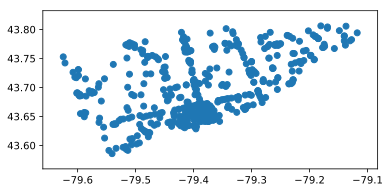

In [34]:
def df_to_gdf(df):
    """takes a dataframe with columns named 'longitude' and 'latitude' 
    to transform to a geodataframe with point features"""
    
    df['coordinates'] = df[['longitude', 'latitude']].values.tolist()
    df['coordinates'] = df['coordinates'].apply(Point)
    df = gpd.GeoDataFrame(df, geometry = 'coordinates')
    return df
gdf_parking = df_to_gdf(parking_ward_hr)
gdf_parking.plot()

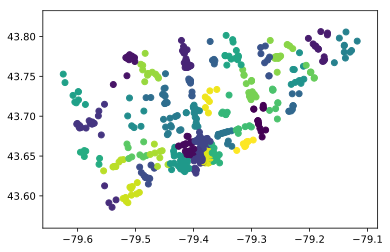

In [35]:
gdf_parking = gdf_parking.reset_index()
gdf_parking2 = gdf_parking[['latitude','longitude']]
gdf_parking2 = gdf_parking2[['latitude','longitude']]

# Scaling the data to normalize
model = KMeans(n_clusters=40).fit(gdf_parking2)
x = gdf_parking2.latitude
y = gdf_parking2.longitude
# Visualize it:
plt.figure(figsize=(6, 4))
plt.scatter(y, x, c=model.labels_.astype(float))
#plt.scatter(y, x, c=['b','c','g','m','r']*4)

In [36]:
gdf_parking2['cluster'] = model.labels_
gdf_parking2

,latitude,longitude,cluster
0,43.788048,-79.276242,10
1,43.795021,-79.267795,32
2,43.801973,-79.169251,3
3,43.804325,-79.168983,3
4,43.805632,-79.137119,17
5,43.806137,-79.180519,3
6,43.767099,-79.157181,17
7,43.768773,-79.177527,3
8,43.769010,-79.175870,3
9,43.770810,-79.173965,3


In [38]:
gdf_parking.head()

,ID,latitude,longitude,Rating,Name,Url,ward,coordinates
0,ChIJuRi7_XDR1IkRM5X4RXTfm8g,43.788048,-79.276242,3.8,Agincourt Recreation Centre,https://maps.google.com/?cid=14455393119458858291,Ward 41,POINT (-79.2762419 43.7880479)
1,ChIJofioV2vR1IkR143Hl-jNgSE,43.795021,-79.267795,3.3,Commander Park Arena,https://maps.google.com/?cid=2414437274109840855,Ward 41,POINT (-79.2677951 43.7950207)
2,ChIJX8tImyLa1IkRuRptGbg-XpQ,43.801973,-79.169251,3.7,Camargue II,https://maps.google.com/?cid=10691051525845621433,Ward 44,POINT (-79.1692513 43.8019728)
3,ChIJ1Xzefyba1IkR6Svpd22heXQ,43.804325,-79.168983,2.8,Meadowvale Rd At Dean Park Rd,https://maps.google.com/?cid=8392916872116906985,Ward 44,POINT (-79.168983 43.804325)
4,ChIJTTTWR9_b1IkRHAE0ODfkhf4,43.805632,-79.137119,4.2,Glen Rouge Campground,https://maps.google.com/?cid=18340315983353479452,Ward 44,POINT (-79.13711909999999 43.8056324)


In [39]:
gdf_parking.shape

(596, 8)

In [40]:
gdf_parking3 = pd.merge(gdf_parking, gdf_parking2).drop_duplicates(subset=['latitude','longitude'])
gdf_parking3.shape

(594, 9)

## Assign Destination Points to nearest parking lots' cluster

In [41]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(gdf_parking3[['longitude','latitude']], gdf_parking3['cluster'])
CT_trips_pts['parking_cluster'] = classifier.predict(CT_trips_pts[['long','lat']])

In [42]:
CT_trips_pts.head()

,charging s,POP06,L_AREA,ward,long,lat,CT_AM_trips,parking_cluster
CTNAME,,,,,,,,
0001.00,2.0,571,6.10,Ward 28,-79.335397,43.647242,1285.060838,39
0002.00,0.0,627,3.17,Ward 28,-79.381859,43.623125,2581.374046,7
0003.00,0.0,0,0.00,Ward 5,-79.451040,43.635331,1004.688287,34
0004.00,0.0,6861,0.34,Ward 14,-79.439767,43.637460,714.248927,21
0005.00,0.0,5089,0.38,Ward 14,-79.430487,43.639907,655.718071,21


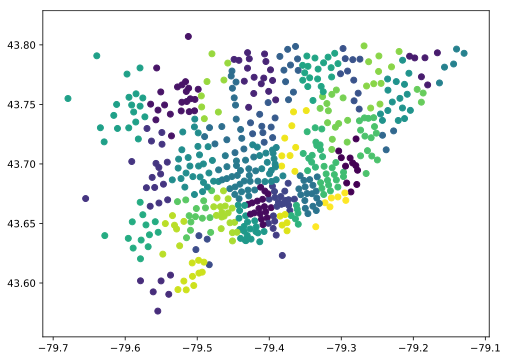

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter(CT_trips_pts['long'], CT_trips_pts['lat'], c = classifier.predict(CT_trips_pts[['long','lat']]).astype(float))

## Create Distance Matrix of Charging Station to Demand Location for Each Cluster

In [44]:
cluster_list = [i for i in range(40)]
for cluster_id in cluster_list:
    df_chg = gdf_parking3.loc[gdf_parking3['cluster']==cluster_id]
    coords_pk = [(x,y) for x,y in zip(df_chg['longitude'],df_chg['latitude'])]
    df_demand = CT_trips_pts.loc[CT_trips_pts['parking_cluster']==cluster_id]
    coords_trip = [(x,y) for x,y in zip(df_demand['long'],df_demand['lat'])]

    distance_matrix = distance.cdist(coords_pk, coords_trip, 'euclidean')
    transfer_ratio = 85 # roughly transfer distance to km
    distance_matrix2 = transfer_ratio*distance_matrix
    df_distance = pd.DataFrame(distance_matrix2, index = df_chg.ID.tolist() ,columns = df_demand.index.tolist())
    # print (df_distance.shape)
    df_distance.to_excel('data/cleaned/distance_mtx_cluster'+str(cluster_id)+'.xlsx')


In [45]:
CT_trips_pts.to_excel('data/cleaned/optimization_CT_AM_trips_cluster.xlsx')

In [46]:
df_parking_cluster = gdf_parking3[['latitude','longitude','Rating','Name','Url','ID','ward','cluster']].copy()
df_parking_cluster.to_excel('data/cleaned/optimization_parking_location_cluster.xlsx')